In [1]:
# Cesar Castrejon,
# Jazhiel Chacon,
# Luis Enrique Andrade Gorjoux,
# Miguel de Jesus Martínez Felipe, and
# Oscar Roberto Chaparro Amaro, 

!pip install ricker
!pip install qiskit

#Libraries
import math
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi

#Qiskit
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, assemble, Aer, transpile
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.quantum_info import Statevector

#Normalization
from sklearn.preprocessing import MinMaxScaler
#Simulation
from ricker import ricker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ricker: filename=ricker-0.1.2-py3-none-any.whl size=3229 sha256=5502f6b82ec5b269fd052887d91fab9693c5d728b4d4532e78cd60dc90121414
  Stored in directory: /root/.cache/pip/wheels/85/34/de/3099f8a54aba9ed44e1766aafb60adb56d2036fedccd1e6612
Successfully built ricker
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 8.7 MB/s 
     |████████████████████████████████| 19.2 MB 8.1 MB/s 
     |████████████████████████████████| 240 kB 51.8 MB/s 
     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 106 kB 34.6 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 49 kB 6.3 MB/s 
     |████████████████████████████████| 943 kB 59.9 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
     

## Discrete Fourier Transform


$\bullet$Discrete:
\begin{equation}
X_{k} = \displaystyle\sum_{n=0}^{N-1} x_{n} \cdot e^{-\frac{j2\pi kn}{N}}
\end{equation}
<br>
<br>
Where: ${-\frac{2\pi kn}{N}} \rightarrow b_{n}$
<br>
<br>
\begin{equation}
X_{k} = x_{0}e^{-b_{0}j} + x_{1}e^{-b_{1}j} + \dots + x_{n-1}e^{-b_{N-1}j}
\end{equation}
<br>


Here there is an example of one array with 8 input samples in the classical part.

## Quantum Fourier Transform

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

As it explained in [3], the Fourier transform occurs in many different versions throughout classical computing, in areas ranging from signal processing to data compression to complexity theory. The quantum Fourier transform (QFT) is the quantum implementation of the discrete Fourier transform over the amplitudes of a wavefunction. It is part of many quantum algorithms, most notably Shor's factoring algorithm and quantum phase estimation [4].

The Quantum Fourier Transform (QFT) on qubits is the operation:

\begin{equation}
\ket{j} \mapsto \frac{1}{2^{n/2}} \sum_{k=0}^{2^n - 1} e^{2\pi ijk / 2^n} \ket{k}
\end{equation}

In [2]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    circuit.barrier()
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    """swap"""
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit#.decompose()

def qft_inser(circuit,n):
    """Insert the QFT"""
    lenghtCircuit = len(circuit.qubits)
    qft_circ = qft(QuantumCircuit(n,name='QFT'), n)
    circuit.append(qft_circ, circuit.qubits[lenghtCircuit-n:lenghtCircuit])
    return circuit#.decompose()

def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    lenghtCircuit = len(circuit.qubits)
    qft_circ = qft(QuantumCircuit(n,name='inv_QFT'), n)
    invqft_circ = qft_circ.inverse()
    circuit.append(invqft_circ, circuit.qubits[lenghtCircuit-n:lenghtCircuit])
    return circuit#.decompose()

## Encoding Classical data into Qubits using Amplitude Encoding
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

Amplitude encoding usually is implemented in quantum machine learning algorithms. The main reason to implement this encoding is the fact that is needed $n=log⁡_{2}M$ qubits to encode a dataset of $M$ inputs. If a quantum machine learning algorithm is a polynomial complexity in $n$, it has a logarithmic runtime dependency on the data set size. Promises of exponential speedups from qubit-efficient.

For this particular experiment, a 1024 1-Dimentional signal is encoded in the following way:
\begin{equation}
n = log_{2} 1024
\end{equation}

\begin{equation}
n = 10
\end{equation}

So 10 qubits are needed for each basis state of the system.

\begin{equation}
\ket{\psi_{signal}} = M_{0} \ket{0000000000} + M_{1} \ket{0000000001} + \cdots +M_{1024} \ket{1111111111}
\end{equation}

Since $\ket{\psi_{signal}}$ is a quantum state, the sum of the amplitudes must be equal to 1.


This means that each amplitude must be normalize. For this normalization the Frobenius norm is applied

\begin{equation}
|| A ||_{F} = \left[∑_{ij} abs(ij)^{2} \right]^{\frac{1}{2}},
\end{equation}

The nuclear norm is the sum of the singular values.

In [3]:
def create_encoded_qc(samples):
    """Encode classical data usign Amplitude encoding"""
    amplitudes = len(samples)
    num_qubits = int(math.log2(amplitudes))
    q = QuantumRegister(num_qubits)
    qc = QuantumCircuit(q)
    normalized_amplitudes = samples / np.linalg.norm(samples) #Normalization
    qc.initialize(normalized_amplitudes, [q[i] for i in range(num_qubits)])
    return qc

## First Example using classical and quantum Fourier transform

In [4]:
example_1 = np.array([0,1,0,0,0,1,0,0])
Fourier_1 = np.fft.fft(example_1)
print(Fourier_1,'Fourier_Classic')

[ 2.+0.j  0.+0.j  0.-2.j  0.+0.j -2.+0.j  0.+0.j  0.+2.j  0.+0.j] Fourier_Classic


In [5]:
#For the Quantum Fourier Transform with need n = log_{2} M qubits
n_qc = int(math.log2(len(example_1)))
qc = create_encoded_qc(example_1)
qc = qft(qc,n_qc)
# qc.draw(output='mpl')
print(qc)
#Execute the circuit
backend = Aer.get_backend('statevector_simulator')
job = backend.run(qc)
result = job.result()
outputstate = result.get_statevector(qc, decimals=1)
recoverState = outputstate/((1/len(example_1))*2)
print(recoverState,'Fourier_quantum')

      ┌──────────────────────────────────────────┐      ░                   »
q0_0: ┤0                                         ├──────░──■────────────────»
      │                                          │      ░  │                »
q0_1: ┤1 Initialize(0,0.70711,0,0,0,0.70711,0,0) ├──────░──┼────────■───────»
      │                                          │┌───┐ ░  │P(π/4)  │P(π/2) »
q0_2: ┤2                                         ├┤ H ├─░──■────────■───────»
      └──────────────────────────────────────────┘└───┘ ░                   »
«            ░          ┌───┐ ░    
«q0_0: ──────░──■───────┤ H ├─░──X─
«      ┌───┐ ░  │P(π/2) └───┘ ░  │ 
«q0_1: ┤ H ├─░──■─────────────░──┼─
«      └───┘ ░                ░  │ 
«q0_2: ──────░────────────────░──X─
«            ░                ░    
Statevector([ 2.+0.j,  0.-0.j,  0.+2.j,  0.+0.j, -2.+0.j,  0.+0.j,  0.-2.j,
             -0.+0.j],
            dims=(2, 2, 2)) Fourier_quantum


In [6]:
# Set the intial state of the simulator to the ground state using from_int
stateTwo = Statevector.from_int(0, 2**n_qc)
# Evolve the state by the quantum circuit
stateTwo = stateTwo.evolve(qc)
#draw using latex
stateTwo.draw('latex')

<IPython.core.display.Latex object>

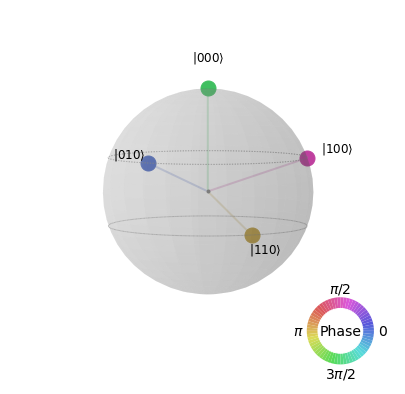

In [7]:
stateTwo.draw('qsphere')

Since in the classical part it was neccesary 8 classical bits, in the quantum circuit $n = log_{2}M$ qubits just are needed $n = 3$ (in this particular case). The following plots show the point in the real part from the Discrete and Quantum Fourier Transform: 

[2.0, 0.0, 2.0, 0.0, 2.0, 0.0, 2.0, 0.0]




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


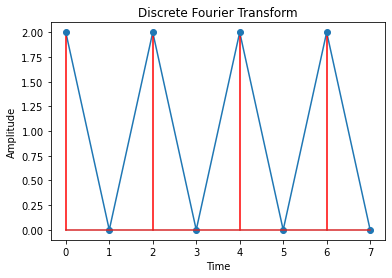

In [8]:
y = []
for x in range(0,len(recoverState)):
    y.append(math.sqrt(recoverState[x].real**2+recoverState[x].imag**2))
print(y)
print("\n")
x = np.arange(len(example_1))
plt.plot(y)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Discrete Fourier Transform')
plt.stem(x,y, 'r', )
plt.show()

[2.0, 0.0, 2.0, 0.0, 2.0, 0.0, 2.0, 0.0]




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


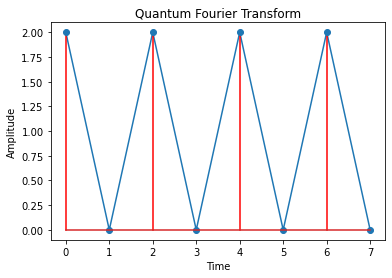

In [9]:
y = []
for x in range(0,len(Fourier_1)):
    y.append(math.sqrt(Fourier_1[x].real**2+Fourier_1[x].imag**2))
print(y)
print("\n")
x = np.arange(len(example_1))
plt.plot(y)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Quantum Fourier Transform')
plt.stem(x,y, 'r', )
plt.show()

# Classical Part using Ricker Wavelet Generator and Discrete Fourier Transform

The general case of the 1D acoustic wave equation (replacing the time derivatives by classical finite diferences) is:

\begin{equation}
  \frac{p(x, t+dt) -2p(x, t)+p(x,t)}{dt^2} = c(x)^2 \frac{\partial^2 p(x,t)}{\partial x^2} + s(x,t)
\end{equation}

where $c^2$ is the squared P-wave velocity, $p(x,t)$ is the pressure field in coordinate $x$ at $t$ time and $s$ is the source term.

In the general case, the pseudospectral method calculates the spatial derivative as follows:
\begin{equation}
    p(x,t) \rightarrow FFT \rightarrow p(k, t) \rightarrow (ik)^2 p(k, t) \rightarrow FFT^{-1} \rightarrow \frac{\partial^2 p(x,t)}{\partial x^2}
\end{equation}



## Ricker Wavelet Generator and Discrete Fourier Transform

We use a Python module called *Ricker Generator* in order to generate the Ricker wavelet amplitudes. This wavelet is defined as:

\begin{equation}
A = \left( 1 - 2\pi^2 f^2 t^2\right) e^{-\pi^2 f^2 t^2}
\end{equation}
where $f$ is the peak frequency and $t$ the time.

In seismic theory, the convolutional model states that any seismic signal is the result of *summing* (actually, convolving) a wavelet with the
reflection coefficient (which is related with changes in rock properties suh as density and velocity) of the medium. In simulation, it's common to
use *zero-phase* wavelets, like the Ricker one, because they tend to provide sharper definition and less distortion between change in rock properties.

In [10]:
# Basic parameters
# ---------------------------------------------------------------
nt    = 1024    # number of time steps
c     = 343.    # acoustic velocity [m/s]
eps   = 0.2     # stability limit
isnap = 50      # snapshot frequency
isx   = 600     # source location #1250
f0    = 60.     # Frequency [Hz](div by 5)
nx    = 1024    # number of grid points in x  #2024

# pressure fields Initialization
p = np.zeros(nx) ; pnew = p ; pold = p ; d2p = p; dp = p   
ap = np.zeros(nx); apnew = ap; apold = ap; ad2p = ap; adp = ap 
sp = np.zeros(nx); spnew = sp; spold = sp; sd2p = sp; sdp = p 

dx = 600./(nx-1)  # calculate space increment
x  = np.arange(0, nx)*dx   # initialize space coordinates
dt = eps*dx/c; # calculate time step from stability criterion

print(dt)

0.0003419884920872413


In [11]:
# source time function
# ---------------------------------------------------------------
t   = np.arange(1, nt+1)*dt  # initialize time axis
T0  = 1./f0
tmp = ricker(f=10, len=0.5, dt=0.002, peak_loc=0.25)#dt, T0)
tmp = np.diff(tmp)
src = np.zeros(nt) 
src[0:np.size(tmp)] = tmp
lam = c*T0

#spatial source function
# ---------------------------------------------------------------
sigma = 2*dx
x0 = x[isx-1]
sg = np.exp(-1/sigma**2 *(x - x0)**2); sg = sg/np.amax(sg)

In [12]:
def fourier_derivative_2nd(f, dx):
    # Length of vector f
    nx = np.size(f)
    # Initialize k vector up to Nyquist wavenumber 
    kmax = np.pi / dx
    dk = kmax / (nx / 2)
    k = np.arange(float(nx))
    k[: int(nx/2)] = k[: int(nx/2)] * dk 
    k[int(nx/2) :] = k[: int(nx/2)] - kmax
    
    # Fourier derivative
    ff = np.fft.fft(f)
#     print(ff)
    ff = (1j*k)**2 * ff
    df_num = np.real(np.fft.ifft(ff))
    return df_num

In [13]:
#Initialize values
for it in range(nt):
#     print(it)
    # ----------------------------------------
    # Fourier Pseudospectral Method
    # ----------------------------------------           
    sd2p  = fourier_derivative_2nd(sp, dx)      # 2nd space derivative     
    spnew = 2*sp - spold + c**2 * dt**2 * sd2p  # Time Extrapolation   
    spnew = spnew + sg*src[it]*dt**2            # Add sources   
    spold, sp = sp, spnew                       # Time levels
    sp[1] = 0; sp[nx-1] = 0 

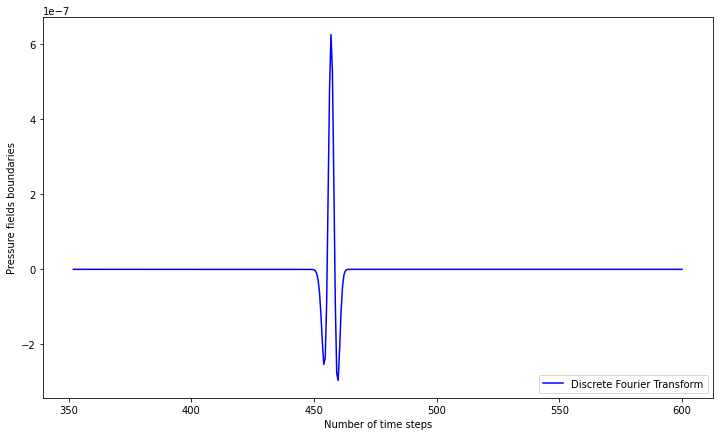

<Figure size 432x288 with 0 Axes>

In [14]:
# Initialize animated plot
# ---------------------------------------------------------------
fig, (ax3) = plt.subplots(1, sharex=True, sharey=True, figsize=(12,7))  
line3 = ax3.plot(x[isx:], sp[isx:], 'b', lw=1.5, label='Discrete Fourier Transform')
# ax1.axis([isx*dx, nx*dx, -6E-7, 6E-7]); ax3.set_xlabel('x [m]')
ax3.legend(loc=4)
plt.xlabel('Number of time steps')
plt.ylabel('Pressure fields boundaries')
plt.ion()   # set interective mode
plt.show()

# ---------------------------------------------------------------
# Time extrapolation
# ---------------------------------------------------------------

for it in range(nt):
#     print(it)
    # ----------------------------------------
    # Fourier Pseudospectral Method
    # ----------------------------------------           
    sd2p  = fourier_derivative_2nd(sp, dx)      # 2nd space derivative     
    spnew = 2*sp - spold + c**2 * dt**2 * sd2p  # Time Extrapolation   
    spnew = spnew + sg*src[it]*dt**2            # Add sources   
    spold, sp = sp, spnew                       # Time levels
    sp[1] = 0; sp[nx-1] = 0     # set boundaries pressure free
    
    # --------------------------------------   
    # Animation plot. Display solution
    if not it % isnap: 
        for l in line3:
            l.remove()
            del l
            
        # -------------------------------------- 
        # Display lines
        line3 = ax3.plot(x[isx:], sp[isx:], 'b', lw=1.5)
        plt.gcf().canvas.draw()

# Quantum Part using Ricker Wavelet Generator and Quantum Fourier Transform

In [15]:
#Create Quantum Circuit
def quantumFourierDerivative(f,dx):
    """Create the Quantum Circuit base on the signal input
    and return the signal in the real part"""
    nx = np.size(f)
    kmax = np.pi / dx
    dk = kmax / (nx / 2)
    k = np.arange(float(nx))
    k[: int(nx/2)] = k[: int(nx/2)] * dk 
    k[int(nx/2) :] = k[: int(nx/2)] - kmax
  # Quantum Fourier derivative
    n_qubits_signal = int(math.log2(len(f)))
    signal_qc = create_encoded_qc(f)
    signal_qc = qft(signal_qc,n_qubits_signal)

  ### This part is to extract the State vector
    backend_state = Aer.get_backend('statevector_simulator')
    job_state = backend_state.run(signal_qc)
    result_state = job_state.result()
    outputstate_2 = result_state.get_statevector(signal_qc, decimals=3)

  ### This part is to extract the data from outputstate_2 for compatibility in Colab and IBM
    i = 0
    outputstate_2_a = []
    while i <= (len(outputstate_2)-1):
      outputstate_2_a.append(outputstate_2[i])
      i += 1
    outputstate_2_aN = np.array(outputstate_2_a)

    recoverStateSignal = outputstate_2_aN/((1/len(f))*2)
    # print(recoverStateSignal,'Fourier_quantum')
    ff = (1j*k)**2 * recoverStateSignal
    df_num = np.real(np.fft.ifft(ff))
    return df_num

In [16]:
quantumFourierDerivative(sp,dx)

array([-0.01814213, -0.03215055,  0.00189971, ..., -0.00780952,
        0.02208156,  0.01918241])

In [17]:
# Basic parameters
# ---------------------------------------------------------------
nt    = 1024    # number of time steps
c     = 343.    # acoustic velocity [m/s]
eps   = 0.2     # stability limit
isnap = 50      # snapshot frequency
isx   = 600    # source location #1250
f0    = 60.     # Frequency [Hz](div by 5)
nx    = 1024    # number of grid points in x  #2024

# pressure fields Initialization
p = np.zeros(nx) ; pnew = p ; pold = p ; d2p = p; dp = p   
ap = np.zeros(nx); apnew = ap; apold = ap; ad2p = ap; adp = ap 
sp = np.zeros(nx); spnew = sp; spold = sp; sd2p = sp; sdp = p 

dx = 600./(nx-1)  # calculate space increment
x  = np.arange(0, nx)*dx   # initialize space coordinates
dt = eps*dx/c; # calculate time step from stability criterion

print(dt)

0.0003419884920872413


In [18]:
# source time function
# ---------------------------------------------------------------
t   = np.arange(1, nt+1)*dt  # initialize time axis
T0  = 1./f0
tmp = ricker(f=10, len=0.5, dt=0.002, peak_loc=0.25)#dt, T0)
tmp = np.diff(tmp)
src = np.zeros(nt) 
src[0:np.size(tmp)] = tmp
lam = c*T0

#spatial source function
# ---------------------------------------------------------------
sigma = 2*dx
x0 = x[isx-1]
sg = np.exp(-1/sigma**2 *(x - x0)**2); sg = sg/np.amax(sg)

In [19]:
#Initialize values
for it in range(nt):
#     print(it)
    # ----------------------------------------
    # Fourier Pseudospectral Method
    # ----------------------------------------           
    sd2p  = fourier_derivative_2nd(sp, dx)      # 2nd space derivative     
    spnew = 2*sp - spold + c**2 * dt**2 * sd2p  # Time Extrapolation   
    spnew = spnew + sg*src[it]*dt**2            # Add sources   
    spold, sp = sp, spnew                       # Time levels
    sp[1] = 0; sp[nx-1] = 0 

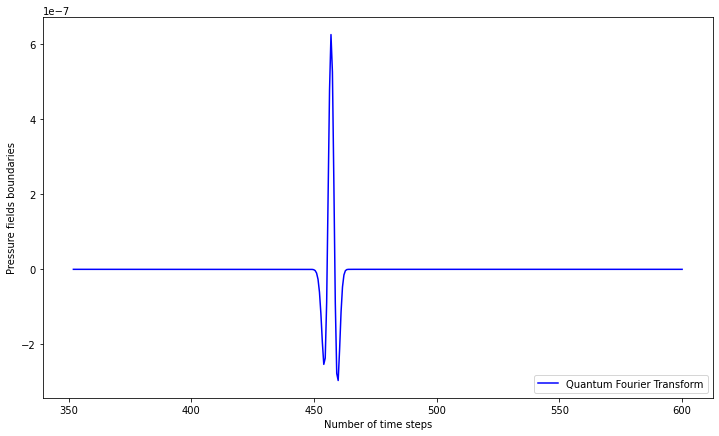

<Figure size 432x288 with 0 Axes>

In [20]:
# Initialize animated plot
# ---------------------------------------------------------------
fig, (ax3) = plt.subplots(1, sharex=True, sharey=True, figsize=(12,7))  
line3 = ax3.plot(x[isx:], sp[isx:], 'b', lw=1.5, label='Quantum Fourier Transform')
ax3.legend(loc=4)
plt.xlabel('Number of time steps')
plt.ylabel('Pressure fields boundaries')
plt.ion()   # set interective mode
plt.show()

# ---------------------------------------------------------------
# Time extrapolation
# ---------------------------------------------------------------
for it in range(nt):
    # ----------------------------------------
    # Quantum Fourier Pseudospectral Method
    # ----------------------------------------           
    sd2p  = quantumFourierDerivative(sp, dx)      # 2nd space derivative     
    spnew = 2*sp - spold + c**2 * dt**2 * sd2p  # Time Extrapolation   
    spnew = spnew + sg*src[it]*dt**2            # Add sources   
    spold, sp = sp, spnew                       # Time levels
    sp[1] = 0; sp[nx-1] = 0     # set boundaries pressure free
       
    # Animation plot. Display solution
    if not it % isnap: 
        for l in line3:
            l.remove()
            del l
        # -------------------------------------- 
        # Display lines
        line3 = ax3.plot(x[isx:], sp[isx:], 'b', lw=1.5)
        
        plt.gcf().canvas.draw()

# References
[1] Igel, H. (2017). Computational seismology: a practical introduction. Oxford University Press.

[2] https://github.com/davofis/computational_seismology/blob/master/05_pseudospectral/fourier_acoustic_1d.ipynb

[3] https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html

[4] M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).

[5] F. Leymann and J. Barzen The bitter truth about gate-based quantum algorithms in the NISQ era 2020 Quantum Sci. Technol. 5

[6] G. H. Golub and C. F. Van Loan, Matrix Computat

